# imports de bibliotecas e de database

In [1]:
import re # biblioteca para expressoes regulares
import os # biblioteca sobre o sistema operacional
import nltk # biblioteca para o preprocessamento
import gensim
import random
import numpy as np # biblioteca usada para trabalhar com vetores e matrizes
import unicodedata # sera usada para remover acentos dos documentos em lingua portuguesa
import pandas as pd # biblioteca usada para trabalhar com dataframes e análise de dados
import sklearn as skl
from zipfile import ZipFile # biblioteca para arquivos zipados
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterSampler
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt




# Download bases de dados e modelo word2vec de 100 dimensões já treinado

In [2]:
url = 'https://github.com/gazzola/corpus_readability_nlp_portuguese/archive/refs/heads/master.zip'
url2 = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s100.zip'

# especifica o local onde ficarao os arquivos
pathFiles = 'dados/'
fileName = 'corpus_readability_nlp_portuguese.zip'

# cria uma pasta onde ficarao os arquivos
if not os.path.isdir(pathFiles):
    os.mkdir(pathFiles)

# faz o download do arquivo
os.system('wget -O %s%s %s' %(pathFiles, fileName, url))
fileName2 = 'cbow_s100.zip'
os.system('wget -O %s%s %s' %(pathFiles, fileName2, url2))

print('Arquivos extraídos com sucesso!')


Arquivos extraídos com sucesso!


In [3]:
# descompacta a base de dados de notícias
z = ZipFile('dados/corpus_readability_nlp_portuguese.zip', 'r')
z.extractall('dados/')
z.close()

z = ZipFile('dados/cbow_s100.zip', 'r')
z.extractall('dados/')
z.close()

In [4]:
def import_Dataset(path):

    files = os.listdir(path)

    dataset = []

    for i, file in enumerate(files):

        # abre o arquivo
        fileTexto = open(path+'/'+file, "r", encoding='utf8', errors='replace') #utf8 #cp1252

        # le o arquivo e armazena o texto dentro da variavel "texto"
        texto = fileTexto.read()

        dataset.append(texto)

    return dataset

# importa as bases de dados
dataset_Fund1 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/1_Ensino_Fundamental_I')
print('Ensino Fundamental 1 importadas com sucesso')
dataset_Fund2 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/2_Ensino_Fundamental_II')
print('Ensino Fundamental 2 importadas com sucesso')
dataset_Medio = import_Dataset('dados/corpus_readability_nlp_portuguese-master/3_Ensino_Medio')
print('Ensino Medio importadas com sucesso')
dataset_Superior = import_Dataset('dados/corpus_readability_nlp_portuguese-master/4_Ensino_Superior')
print('Ensino Superior importadas com sucesso')

# concatena as bases de dados
dataset = np.asarray( dataset_Fund1+dataset_Fund2+dataset_Medio+dataset_Superior)


# cria um vetor para cada classe
target_Fund1 = np.zeros( len(dataset_Fund1), dtype=int )
target_Fund2 = np.ones( len(dataset_Fund2), dtype=int )
target_Medio = np.full(len(dataset_Medio), 2)
target_Superior = np.full(len(dataset_Superior), 3)

# concateca os vetores de classe
target = np.concatenate((target_Fund1, target_Fund2, target_Medio, target_Superior))

# obtem as classes do problema
classes = np.unique(target)

print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. textos target: %d' %len(target))

Ensino Fundamental 1 importadas com sucesso
Ensino Fundamental 2 importadas com sucesso
Ensino Medio importadas com sucesso
Ensino Superior importadas com sucesso

Qtd. textos dataset: 2076
Qtd. textos target: 2076


In [5]:
print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. Classes: %d' %len(pd.unique(classes)))
qtype = {}
for i in pd.unique(classes):
    print('Classe: %s, Qtd: %d, Porcentagem: %.2f' %(i, len(target[target==i]), len(target[target==i])/len(target)*100))
    qtype[i] = len(target[target==i])
    


Qtd. textos dataset: 2076
Qtd. Classes: 4
Classe: 0, Qtd: 297, Porcentagem: 14.31
Classe: 1, Qtd: 325, Porcentagem: 15.66
Classe: 2, Qtd: 628, Porcentagem: 30.25
Classe: 3, Qtd: 826, Porcentagem: 39.79


# Balanceamento do Dataset
Como o dataset estava muito desbalanceado, com uma classe que representa mais de 74% e outra representando apenas 1.26%, então é necessário o balanceamento

In [6]:
#printar tipo do dataset
print(type(dataset))
#transformar em dataframe juntando com o target
df = pd.DataFrame({'text': dataset, 'target': target})

<class 'numpy.ndarray'>


In [7]:
print(df.head())

                                                text  target
0   O jovem inventor Nicephóre Niepce foi quem co...       0
1   As coisas pioraram nas cidades, porque os pré...       0
2   Você acredita que mais de 600 mil lusitanos v...       0
3   Depois de dar um duro danado, acordando muito...       0
4   Para que todas essas coisas existam, as pesso...       0


In [8]:
print(qtype)
mean = np.array(list(qtype.values())).mean()
print(mean.round())

# Funcao para deletar linhas aleatoriamente
def delete_random_rows(df, type_value, num_to_delete):
    indices = df[df['target'] == type_value].index.tolist()
    if len(indices) <= num_to_delete:
        return df.drop(index=indices)
    else:
        random_indices = random.sample(indices, num_to_delete)
        return df.drop(index=random_indices)

# Funcao para duplicar linhas aleatoriamente
def duplicate_random_rows(df, type_value, num_to_duplicate):
    indices = df[df['target'] == type_value].index.tolist()
    if len(indices) == 0:
        return df
    else:
        new_rows = df.loc[random.sample(indices, 1)]  # Sample existing row
        new_rows = pd.concat([new_rows] * num_to_create, ignore_index=True)
        return pd.concat([df, new_rows])

# Processa cada tipo de texto
for type_value in pd.unique(df['target']):
    count = qtype[type_value]
    if count > mean:
        num_to_delete = min(count - int(mean), count)
        df = delete_random_rows(df, type_value, num_to_delete)
    elif count < mean:
        num_to_create = int(mean) - count
        df = duplicate_random_rows(df, type_value, num_to_create)
        
print('\nAfter balancing:')
print('Qtd. textos dataset: %d' % len(df))
print('Qtd. Classes: %d' % len(pd.unique(df['target'])))
for i in pd.unique(df['target']):
    print('Classe: %s, Qtd: %d' % (i, len(df[df['target'] == i])))

print(df)

{0: 297, 1: 325, 2: 628, 3: 826}
519.0

After balancing:
Qtd. textos dataset: 2076
Qtd. Classes: 4
Classe: 0, Qtd: 519
Classe: 1, Qtd: 519
Classe: 2, Qtd: 519
Classe: 3, Qtd: 519
                                                  text  target
0     O jovem inventor Nicephóre Niepce foi quem co...       0
1     As coisas pioraram nas cidades, porque os pré...       0
2     Você acredita que mais de 600 mil lusitanos v...       0
3     Depois de dar um duro danado, acordando muito...       0
4     Para que todas essas coisas existam, as pesso...       0
..                                                 ...     ...
189  Curiosidades. Quando as divergências dos povos...       1
190  Curiosidades. Quando as divergências dos povos...       1
191  Curiosidades. Quando as divergências dos povos...       1
192  Curiosidades. Quando as divergências dos povos...       1
193  Curiosidades. Quando as divergências dos povos...       1

[2076 rows x 2 columns]


# Preprocessing

In [9]:
# Download stopwords corpus
nltk.download('stopwords')

# Download RSLPStemmer
nltk.download('rslp')

from nltk.stem import RSLPStemmer # para fazer a estemização em documentos da lingua portuguesa

def preprocessing_portuguese(text, stemming = False, stopwords = False):

    # Lower case
    text = text.lower()

    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text)

    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)

    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+')
    text = re.sub(regex, " ", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+.[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+,[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "NUMERO", text)


    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split()

    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove stopwords
    if stopwords:
        words = text.split() # separa o texto em palavras
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
        text = " ".join( words )

    # aplica estemização
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [ stemmer_method.stem(w) for w in words ]
        text = " ".join( words )

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )

    return text

class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=False, stopwords=False):
        self.stemming = stemming
        self.stopwords = stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [preprocessing_portuguese(x, self.stemming, self.stopwords) for x in X]
    

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mathe\AppData\Local\Temp\ipykernel_22228\1791963403.py:23: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('(http|https)://[^\s]*')
C:\Users\mathe\AppData\Local\Temp\ipykernel_22228\1791963403.py:27: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('[^\s]+@[^\s]+')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# funções para o embedding


In [10]:
class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, pretreinado, vector_size, window, min_count ):
        self.pretreinado = pretreinado
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        
        if self.pretreinado:
            self.model = KeyedVectors.load_word2vec_format('dados/cbow_s100.txt')
        else:
            self.model = Word2Vec(sentences = X,
                          vector_size = self.vector_size,
                          window = self.window,
                          min_count = self.min_count)
        return self


    def transform(self, X, y=None):
        if self.pretreinado:
            return self.dataset2featureMatrix2(X, self.model)
        else:
            return self.dataset2featureMatrix(X, self.model)
    
    def getDocvector(self, model, doc):

        wordList = []
        for word in doc:

            try:
                vec = model.wv[word]
                wordList.append(vec)
            except:
                pass

        if len(wordList)>0:
            vetorMedio = np.mean( wordList, axis=0 )
        else:
            vetorMedio = np.zeros( model.vector_size )

        return vetorMedio

    def dataset2featureMatrix(self, dataset, embeddingModel):

        X_embedding = []
        for doc in dataset:
            vec = self.getDocvector(embeddingModel, doc)
            X_embedding.append(vec)

        X_embedding = np.array(X_embedding)

        return X_embedding
    

    def getDocvector2(self, model, doc):
        wordList2 = []
        for word in doc:
            try:
                vec = model[word]
                wordList2.append(vec)
            except:
                pass
        if len(wordList2)>0:
            vetorMedio = np.mean( wordList2, axis=0 )
        else:        
            vetorMedio = np.zeros( model.vector_size )

        return vetorMedio

    def dataset2featureMatrix2(self, dataset, embeddingModel):

        word2v = []
        for doc in dataset:
            vec = self.getDocvector2(embeddingModel, doc)
            word2v.append(vec)

        word2v = np.array(word2v)

        return word2v

# nuvem de palavra do dataset

é  possivel observar que precisa do preprocessamento

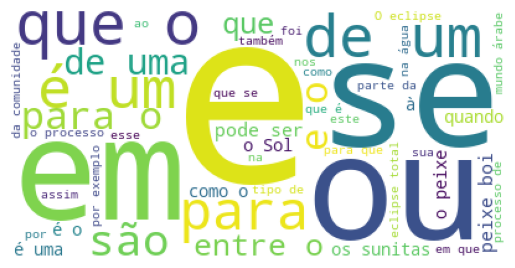

In [11]:
wc = WordCloud(min_font_size = 10, max_font_size = 200, 
               background_color = "white", relative_scaling=0.5)

# Adicione o texto à nuvem de palavras
wc.generate(" ".join(df['text']))

# Plote a nuvem de palavras
plt.imshow(wc)
plt.axis("off")
plt.show()

# Divisão do dataset 


In [12]:
dataset = df['text']
target = df['target']

display(dataset.head())
display(target.head())

0     O jovem inventor Nicephóre Niepce foi quem co...
1     As coisas pioraram nas cidades, porque os pré...
2     Você acredita que mais de 600 mil lusitanos v...
3     Depois de dar um duro danado, acordando muito...
4     Para que todas essas coisas existam, as pesso...
Name: text, dtype: object

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset,  # Dados com os títulos e textos
    target,   # Classes correspondentes
    test_size=0.2,  # Porcentagem dos dados a serem usados como conjunto de teste
    random_state=42  # Semente para a geração de números aleatórios para reprodutibilidade
)
display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())
print(X_train.shape)
print(X_test.shape)

22      Curiosidades. Quando as divergências dos povos...
300     Saúde e Bem-estar. Cansado, após um dia de int...
1389    Logística/Embalagem/Metal/Vantagens e desvanta...
823      Experiência religiosa/Ponto de vista religios...
692      Pela propriedade transitiva das relações de e...
Name: text, dtype: object

22      1
300     1
1389    3
823     2
692     2
Name: target, dtype: int32

307     Sociologia. O racismo consiste numa teoria que...
1192     Estas revelações suscitaram o interesse e a i...
775      Sabendo-se que a aceleração de uma matéria qu...
237     Desde o momento em que nasce, toda criança se ...
1029     A cidade do Rio de Janeiro no século XX/Segun...
Name: text, dtype: object

307     1
1192    2
775     2
237     0
1029    2
Name: target, dtype: int32

(1660,)
(416,)


# definição dos pipeline e execução do Grid Search

In [14]:
RF = RandomForestClassifier()

pipelines = [
    ('Floresta Aleatoria TF', Pipeline([
        ('preprocessing', Preprocessing()),
    ('TF', CountVectorizer()),
    ('clf', RF),
    ])),
    ('Floresta Aleatoria TF-IDF', Pipeline([
        ('preprocessing', Preprocessing()),
        ('vect', TfidfVectorizer()),
        ('clf', RF),
    ])),
    ('Floresta Aleatoria Binario', Pipeline([
        ('preprocessing', Preprocessing()),
        ('vect', CountVectorizer(binary=True)),
        ('clf', RF),
    ])),
    ('Floresta Aleatoria Word2Vec', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado=False, vector_size=200, window=3,min_count=1)),
        ('scaler', MinMaxScaler()),
        ('clf', RF),
    ])),
    ('Floresta Aleatoria Word2Vec (pre-treinado)', Pipeline([
        ('preprocessing', Preprocessing()),
        ('w2v', Embedding(pretreinado=True, vector_size=200, window=3,min_count=1)),
        ('scaler', MinMaxScaler()),
        ('clf', RF),
    ])),
]

# Definindo a grade de parâmetros
parameters = {
    'preprocessing__stemming': [ True, False],
    'preprocessing__stopwords': [ True, False],
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [None, 5, 10, 20],
}

param_distributions = ParameterSampler(parameters, n_iter=5)

best_auc_pipeline = 0
best_pipeline = None
preprocessed_X_train = None
for name, pipeline in pipelines:
    best_accuracy = 0
    best_auc = 0
    best_params = None
    print("\nMétodo: ", name)

    for params in param_distributions:
        
# Verifica se os dados pré-processados já existem no dicionário
        
        pipeline.set_params(**params)
        # Ajusta o pipeline aos dados pré-processados
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test )
        Y_pred_proba = pipeline.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro'  )
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, Y_pred_proba, average='macro', multi_class='ovr')
        # Se o auc for melhor que o melhor auc até agora, atualiza o melhor auc e os melhores parâmetros
        if auc > best_auc:
            best_accuracy = accuracy
            best_macro = macro_f1
            best_precision = precision
            best_recall = recall
            best_params = params
            best_pipeline = pipeline
            best_auc = auc

    
    if best_auc > best_auc_pipeline:
        best_auc_pipeline = best_auc
        best_pipeline = pipeline
    print("Melhor Acurácia: ", best_accuracy)
    print("Melhor Macro F1: ", best_macro)
    print("Melhor precisão: ", best_precision)
    print("Melhor revocação: ", best_recall)
    print("Melhor AUC: ", best_auc)
    print("Melhores Parâmetros: ", best_params)


Método:  Floresta Aleatoria TF
Melhor Acurácia:  0.8774038461538461
Melhor Macro F1:  0.8760146012821596
Melhor precisão:  0.8824652127143817
Melhor revocação:  0.8813291003013345
Melhor AUC:  0.9806972544527439
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': False, 'clf__n_estimators': 150, 'clf__max_depth': None}

Método:  Floresta Aleatoria TF-IDF
Melhor Acurácia:  0.8581730769230769
Melhor Macro F1:  0.8562786920272021
Melhor precisão:  0.8656139265713111
Melhor revocação:  0.863285622040465
Melhor AUC:  0.9823236350988084
Melhores Parâmetros:  {'preprocessing__stopwords': False, 'preprocessing__stemming': False, 'clf__n_estimators': 200, 'clf__max_depth': None}

Método:  Floresta Aleatoria Binario
Melhor Acurácia:  0.8605769230769231
Melhor Macro F1:  0.8592776513215961
Melhor precisão:  0.8693039034065565
Melhor revocação:  0.8651334481274214
Melhor AUC:  0.9835193101475952
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessin